<a href="https://colab.research.google.com/github/ashouy/predicao_api/blob/master/predicao_umidade_jp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento das bases iniciais

## Importações necessárias

In [61]:
## importações necessárias

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(100, ), (7,)], #default e heurístico
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 1000, 5000, 10000]
}

## Classe runmodel


In [7]:

class runmodel:
  '''
    Parâmetros de entrada:

    X: atributos de entradas
    y: atributo alvo
    model: algoritmo para construção do estimador
    cv: se None faz N holdouts, se int faz validação cruzada (ambos com estratificação por classe)
    n = quantidade de repetições da amostragem

    Guardar as métricas de cada execução (armazenametricas) e 
    Mostrar os valores médios com desvio padrão para as métricas (mostraresultadomedio) 

    Se dataset tiver mais de 2 classes, adaptar resultados    
  '''

  def __init__(self, X, y, model, cv = None, n = 1):
    
    self.__resultados = {
      'precision_0': [],
      'recall_0': [],
      'f1_0': [],
      'support_0': [],
      'precision_1': [],
      'recall_1': [],
      'f1_1': [],
      'support_1' : [],
      'accuracy' : [],
      'precision_wavg' : [],
      'recall_wavg' : [],
      'f1_wavg' : [],
      'support_wavg' : []
    }

    if cv is None:
      print(f'{n} holdouts')
      for i in range(n):
        self.__avaliamodelo(X, y, model)
    
    else:
      print(f'{n} validação cruzada com {cv} folds')
      for i in range(n):
        self.__avaliamodelo_cv(X, y, model, cv)

  @property
  def resultados(self):
    return self.__resultados

  def __avaliamodelo(self, X, y, model):
    #gera as amostras de treino (2/3) e teste (1/3) com estratificação por classe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)
    # Treina o modelo usando os dados de treino
    model.fit(X_train,y_train)
    # Testa modelo usando os dados de teste
    pred = model.predict(X_test)
    #armazena resultado
    self.__armazenametricas(metrics.classification_report(y_test,pred, output_dict= True))

  def __avaliamodelo_cv(self, X, y, model, cv):
    #gera as amostras para cv folds com embaralhamento (permite fazer várias validações cruzadas)
    skf = StratifiedKFold(shuffle=True, n_splits=cv)
    #para cada fold: treina, testa e armazena os resultados
    for train_index, test_index in skf.split(X, y):
      model.fit(X.iloc[train_index], y.iloc[train_index])
      pred = model.predict(X.iloc[test_index])
      self.__armazenametricas(metrics.classification_report(y.iloc[test_index], pred, output_dict= True))

  def __armazenametricas(self, d):
    self.__resultados['precision_0'].append(d['0']['precision'])
    self.__resultados['recall_0'].append(d['0']['recall'])
    self.__resultados['f1_0'].append(d['0']['f1-score'])
    self.__resultados['support_0'].append(d['0']['support'])

    self.__resultados['precision_1'].append(d['1']['precision'])
    self.__resultados['recall_1'].append(d['1']['recall'])
    self.__resultados['f1_1'].append(d['1']['f1-score'])
    self.__resultados['support_1'].append(d['1']['support'])

    self.__resultados['accuracy'].append(d['accuracy'])
    
    self.__resultados['precision_wavg'].append(d['weighted avg']['precision'])
    self.__resultados['recall_wavg'].append(d['weighted avg']['recall'])
    self.__resultados['f1_wavg'].append(d['weighted avg']['f1-score'])
    self.__resultados['support_wavg'].append(d['weighted avg']['support'])

  def mostraresultadomedio(self):
    print(f"\t\t precision \t recall \t f1-score \t support\n")
    print(f"0 \t\t {round(np.mean(self.__resultados['precision_0']), 2)}({round(np.std(self.__resultados['precision_0']),2)}) \t {round(np.mean(self.__resultados['recall_0']),2)}({round(np.std(self.__resultados['recall_0']),2)}) \t {round(np.mean(self.__resultados['f1_0']),2)}({round(np.std(self.__resultados['f1_0']),2)}) \t {round(np.mean(self.__resultados['support_0']),2)}({round(np.std(self.__resultados['support_0']),2)})\n")
    print(f"1 \t\t {round(np.mean(self.__resultados['precision_1']), 2)}({round(np.std(self.__resultados['precision_1']),2)}) \t {round(np.mean(self.__resultados['recall_1']),2)}({round(np.std(self.__resultados['recall_1']),2)}) \t {round(np.mean(self.__resultados['f1_1']),2)}({round(np.std(self.__resultados['f1_1']),2)}) \t {round(np.mean(self.__resultados['support_1']),2)}({round(np.std(self.__resultados['support_1']),2)})\n")
    print(f"accuracy \t\t  \t\t  \t {round(np.mean(self.__resultados['accuracy']), 2)}({round(np.std(self.__resultados['accuracy']),2)}) \t\t \n")
    print(f"weighted avg \t {round(np.mean(self.__resultados['precision_wavg']), 2)}({round(np.std(self.__resultados['precision_wavg']),2)}) \t {round(np.mean(self.__resultados['recall_wavg']),2)}({round(np.std(self.__resultados['recall_wavg']),2)}) \t {round(np.mean(self.__resultados['f1_wavg']),2)}({round(np.std(self.__resultados['f1_wavg']),2)}) \t {round(np.mean(self.__resultados['support_wavg']),2)}({round(np.std(self.__resultados['support_wavg']),2)})\n")

## Base 24 horas


In [23]:
#Apresentação

base24 = pd.read_csv("https://raw.githubusercontent.com/ashouy/predicao_api/master/bases_iniciais/base24h.csv")


base24.describe()

,hora_em_minutos,temperatura_real,umidade_real
count,1440.000000,1440.000000,1440.000000
mean,720.327083,29.163194,70.128472
std,409.914479,0.391580,2.626273
min,0.000000,28.000000,63.000000
25%,372.750000,29.000000,68.000000
50%,723.000000,29.000000,71.000000
75%,1069.250000,29.000000,72.000000
max,1439.000000,30.000000,77.000000


In [44]:
base24Temperatura = base24.drop(columns=['umidade_real','data'], axis=1)
base24Umidade = base24.drop(columns=[' temperatura_real','data'], axis=1)

print(base24Umidade.head())
print(base24Temperatura.head())


    hora_em_minutos  umidade_real
0               705            63
1               706            68
2               707            70
3               707            65
4               708            66
    hora_em_minutos   temperatura_real
0               705               29.0
1               706               29.0
2               707               29.0
3               707               29.0
4               708               29.0


### grid umidade 24h

In [ ]:
X_train_umidade24, X_test_umidade24, y_train_umidade24, y_test_umidade24 = train_test_split(base24Umidade.drop(columns=['umidade_real']), base24Umidade['umidade_real'],test_size=0.33)
grid_umidade24 = GridSearchCV(MLPClassifier(),param_grid, verbose = 1)

grid_umidade24.fit(X_train_umidade24,y_train_umidade24)


In [52]:
grid_umidade24.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.001,
 'max_iter': 5000}

In [48]:
grid_umidade24.best_score_

0.5301165803108809

In [49]:
pred_umidade24 = grid_umidade24.predict(X_test_umidade24)
print(metrics.classification_report(y_test_umidade24,pred_umidade24))

              precision    recall  f1-score   support

          64       0.00      0.00      0.00        14
          65       0.00      0.00      0.00        18
          66       0.34      0.73      0.46        37
          67       0.22      0.41      0.28        27
          68       0.00      0.00      0.00        38
          69       0.26      0.64      0.37        33
          70       0.67      0.18      0.28        57
          71       0.51      0.37      0.43        51
          72       0.58      0.88      0.70       137
          73       0.67      0.05      0.10        37
          74       0.00      0.00      0.00        10
          75       0.00      0.00      0.00         6
          76       0.00      0.00      0.00         8
          77       0.00      0.00      0.00         3

    accuracy                           0.44       476
   macro avg       0.23      0.23      0.19       476
weighted avg       0.41      0.44      0.37       476



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### grid temperatura 24h

In [53]:
X_train_temperatura24, X_test_temperatura24, y_train_temperatura24, y_test_temperatura24 = train_test_split(base24Temperatura.drop(columns=[' temperatura_real']), base24Temperatura[' temperatura_real'],test_size=0.33)

grid_temperatura24 = GridSearchCV(MLPClassifier(),param_grid, verbose = 1)

grid_temperatura24.fit(X_train_temperatura24,y_train_temperatura24)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(100,), (7,)],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'max_iter': [200, 1000, 5000, 10000]},
             verbose=1)

In [54]:
grid_temperatura24.best_params_

{'activation': 'identity',
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.001,
 'max_iter': 5000}

In [55]:
grid_temperatura24.best_score_

0.8246923575129534

In [57]:
pred_temperatura24 = grid_temperatura24.predict(X_test_temperatura24)
print(metrics.classification_report(y_test_temperatura24,pred_temperatura24))

              precision    recall  f1-score   support

        28.0       0.00      0.00      0.00         5
        29.0       0.81      1.00      0.90       386
        30.0       0.00      0.00      0.00        85

    accuracy                           0.81       476
   macro avg       0.27      0.33      0.30       476
weighted avg       0.66      0.81      0.73       476



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Base 48 horas

In [59]:
#Apresentação

base48 = pd.read_csv("https://raw.githubusercontent.com/ashouy/predicao_api/master/bases_iniciais/base48h.csv")


base48.describe()

,hora_em_minutos,temperatura_real,umidade_real
count,2880.000000,2880.000000,2880.000000
mean,723.573958,28.970486,69.412500
std,408.389202,0.545432,2.404115
min,0.000000,27.000000,61.000000
25%,378.000000,29.000000,68.000000
50%,733.000000,29.000000,69.000000
75%,1069.250000,29.000000,71.000000
max,1439.000000,31.000000,77.000000


In [60]:
base48Temperatura = base48.drop(columns=['umidade_real','data'], axis=1)
base48Umidade = base48.drop(columns=[' temperatura_real','data'], axis=1)

print(base48Umidade.head())
print(base48Temperatura.head())


    hora_em_minutos  umidade_real
0               705            63
1               706            68
2               707            70
3               707            65
4               708            66
    hora_em_minutos   temperatura_real
0               705               29.0
1               706               29.0
2               707               29.0
3               707               29.0
4               708               29.0


### grid umidade 48h

In [62]:
X_train_umidade48, X_test_umidade48, y_train_umidade48, y_test_umidade48 = train_test_split(base48Umidade.drop(columns=['umidade_real']), base48Umidade['umidade_real'],test_size=0.33)
grid_umidade48 = GridSearchCV(MLPClassifier(),param_grid, verbose = 1)

grid_umidade48.fit(X_train_umidade48,y_train_umidade48)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: 

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(100,), (7,)],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'max_iter': [200, 1000, 5000, 10000]},
             verbose=1)

In [63]:
grid_umidade48.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.001,
 'max_iter': 10000}

In [64]:
grid_umidade48.best_score_

0.2695538658232959

In [65]:
pred_umidade48 = grid_umidade48.predict(X_test_umidade48)
print(metrics.classification_report(y_test_umidade48,pred_umidade48))

              precision    recall  f1-score   support

          62       0.00      0.00      0.00        10
          63       0.00      0.00      0.00        15
          64       0.00      0.00      0.00        15
          65       0.00      0.00      0.00        14
          66       0.00      0.00      0.00        43
          67       0.00      0.00      0.00        63
          68       0.06      0.05      0.06       162
          69       0.15      0.29      0.20       163
          70       0.32      0.64      0.43       166
          71       0.37      0.18      0.25        87
          72       0.46      0.39      0.42       169
          73       0.00      0.00      0.00        30
          74       0.00      0.00      0.00         5
          75       0.00      0.00      0.00         3
          76       0.00      0.00      0.00         6

    accuracy                           0.26       951
   macro avg       0.09      0.10      0.09       951
weighted avg       0.21   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### grid temperatura 48h

In [66]:
X_train_temperatura48, X_test_temperatura48, y_train_temperatura48, y_test_temperatura48 = train_test_split(base48Temperatura.drop(columns=[' temperatura_real']), base48Temperatura[' temperatura_real'],test_size=0.33)

grid_temperatura48 = GridSearchCV(MLPClassifier(),param_grid, verbose = 1)

grid_temperatura48.fit(X_train_temperatura48,y_train_temperatura48)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: 

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(100,), (7,)],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'max_iter': [200, 1000, 5000, 10000]},
             verbose=1)

In [67]:
grid_temperatura48.best_params_

{'activation': 'tanh',
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.001,
 'max_iter': 200}

In [68]:
grid_temperatura48.best_score_

0.7179812933180809

In [69]:
pred_temperatura48 = grid_temperatura48.predict(X_test_temperatura48)
print(metrics.classification_report(y_test_temperatura48,pred_temperatura48))

              precision    recall  f1-score   support

        27.0       0.00      0.00      0.00         2
        28.0       0.00      0.00      0.00       160
        29.0       0.71      1.00      0.83       674
        30.0       0.00      0.00      0.00       114
        31.0       0.00      0.00      0.00         1

    accuracy                           0.71       951
   macro avg       0.14      0.20      0.17       951
weighted avg       0.50      0.71      0.59       951



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Base 72 horas

In [70]:
#Apresentação

base72 = pd.read_csv("https://raw.githubusercontent.com/ashouy/predicao_api/master/bases_iniciais/base72h.csv")

base72.describe()

,hora_em_minutos,temperatura_real,umidade_real
count,4320.000000,4320.000000,4320.000000
mean,722.993750,28.925463,69.775926
std,409.079988,0.603302,2.755663
min,0.000000,27.000000,60.000000
25%,375.000000,29.000000,68.000000
50%,734.500000,29.000000,70.000000
75%,1069.250000,29.000000,72.000000
max,1439.000000,31.000000,77.000000


In [71]:
base72Temperatura = base72.drop(columns=['umidade_real','data'], axis=1)
base72Umidade = base72.drop(columns=[' temperatura_real','data'], axis=1)

print(base72Umidade.head())
print(base72Temperatura.head())

    hora_em_minutos  umidade_real
0               705            63
1               706            68
2               707            70
3               707            65
4               708            66
    hora_em_minutos   temperatura_real
0               705               29.0
1               706               29.0
2               707               29.0
3               707               29.0
4               708               29.0


### grid umidade 72h

In [72]:
X_train_umidade72, X_test_umidade72, y_train_umidade72, y_test_umidade72 = train_test_split(base72Umidade.drop(columns=['umidade_real']), base72Umidade['umidade_real'],test_size=0.33)
grid_umidade72 = GridSearchCV(MLPClassifier(),param_grid, verbose = 1)

grid_umidade72.fit(X_train_umidade72,y_train_umidade72)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: 

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(100,), (7,)],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'max_iter': [200, 1000, 5000, 10000]},
             verbose=1)

In [73]:
grid_umidade72.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.001,
 'max_iter': 1000}

In [74]:
grid_umidade72.best_score_

0.20456520310044163

In [75]:
pred_umidade72 = grid_umidade72.predict(X_test_umidade72)
print(metrics.classification_report(y_test_umidade72,pred_umidade72))

              precision    recall  f1-score   support

          60       0.00      0.00      0.00         1
          61       0.00      0.00      0.00         6
          62       0.00      0.00      0.00        11
          63       0.00      0.00      0.00        22
          64       0.00      0.00      0.00        21
          65       0.00      0.00      0.00        22
          66       0.00      0.00      0.00        66
          67       0.00      0.00      0.00        96
          68       0.20      0.51      0.28       182
          69       0.21      0.19      0.20       216
          70       0.19      0.46      0.26       179
          71       0.27      0.11      0.16       137
          72       0.31      0.16      0.21       217
          73       0.36      0.27      0.31       167
          74       0.24      0.13      0.17        68
          75       0.00      0.00      0.00         8
          76       0.00      0.00      0.00         6
          77       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### grid temperatura 72h

In [76]:
X_train_temperatura72, X_test_temperatura72, y_train_temperatura72, y_test_temperatura72 = train_test_split(base72Temperatura.drop(columns=[' temperatura_real']), base72Temperatura[' temperatura_real'],test_size=0.33)

grid_temperatura72 = GridSearchCV(MLPClassifier(),param_grid, verbose = 1)

grid_temperatura72.fit(X_train_temperatura72,y_train_temperatura72)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: 

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(100,), (7,)],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'max_iter': [200, 1000, 5000, 10000]},
             verbose=1)

In [77]:
grid_temperatura72.best_params_

{'activation': 'identity',
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.001,
 'max_iter': 5000}

In [78]:
grid_temperatura72.best_score_

0.6319976573378513

In [79]:
pred_temperatura72 = grid_temperatura72.predict(X_test_temperatura72)
print(metrics.classification_report(y_test_temperatura72,pred_temperatura72))

              precision    recall  f1-score   support

        28.0       0.00      0.00      0.00       309
        29.0       0.64      1.00      0.78       907
        30.0       0.00      0.00      0.00       209
        31.0       0.00      0.00      0.00         1

    accuracy                           0.64      1426
   macro avg       0.16      0.25      0.19      1426
weighted avg       0.40      0.64      0.49      1426



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Avaliação geral

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

client_x = "https://raw.githubusercontent.com/BiaChacon/prediction-service/master/client/data/client_x.csv"
client_y = "https://raw.githubusercontent.com/BiaChacon/prediction-service/master/client/data/client_y.csv"
client_z = "https://raw.githubusercontent.com/BiaChacon/prediction-service/master/client/data/client_z.csv"






x_1 = pd.read_csv(client_x)
x_2 = pd.read_csv(client_x)

y_1 = pd.read_csv(client_y)
y_2 = pd.read_csv(client_y)

z_1 = pd.read_csv(client_z)
z_2 = pd.read_csv(client_z)

# Setting the date in a string var...
datetime_format = "%d/%m/%Y %H:%M"
date_read = datetime.now()
date_time_last = str(date_read.strftime(datetime_format))

for i in range(len(x_1.datetime)):
  datetime_in_string = x_1.datetime[i]
  dt = datetime.strptime(datetime_in_string, datetime_format)
  hora = dt.hour*60
  t = hora+dt.minute
  x_1.datetime[i] = t

for i in range(len(y_1.datetime)):
  datetime_in_string = y_1.datetime[i]
  dt = datetime.strptime(datetime_in_string, datetime_format)
  hora = dt.hour*60
  t = hora+dt.minute
  y_1.datetime[i] = t

for i in range(len(z_1.datetime)):
  datetime_in_string = z_1.datetime[i]
  dt = datetime.strptime(datetime_in_string, datetime_format)
  hora = dt.hour*60
  t = hora+dt.minute
  z_1.datetime[i] = t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
x_1.corr()

,temperature real,temperature predict,humidity real,humidity predict
temperature real,1.000000,0.397653,-0.987668,0.061959
temperature predict,0.397653,1.000000,-0.395343,0.462533
humidity real,-0.987668,-0.395343,1.000000,-0.063518
humidity predict,0.061959,0.462533,-0.063518,1.000000


In [ ]:
y_1.corr()

,temperature real,temperature predict,humidity real,humidity predict
temperature real,1.000000,0.763653,-0.790844,-0.420375
temperature predict,0.763653,1.000000,-0.667431,-0.508260
humidity real,-0.790844,-0.667431,1.000000,0.514975
humidity predict,-0.420375,-0.508260,0.514975,1.000000


In [ ]:
z_1.corr()

,temperature real,temperature predict,humidity real,humidity predict
temperature real,1.000000,0.163673,-0.988979,0.732196
temperature predict,0.163673,1.000000,-0.150679,0.582622
humidity real,-0.988979,-0.150679,1.000000,-0.737385
humidity predict,0.732196,0.582622,-0.737385,1.000000


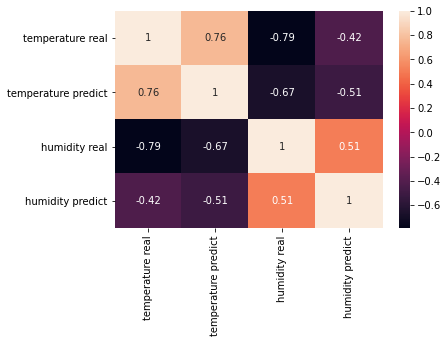

In [ ]:
sns.heatmap(y_1.corr(), annot=True)

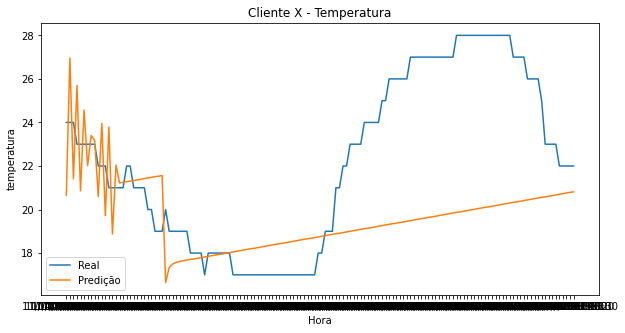

In [ ]:
fig = plt.figure()

plt.plot(x_2.datetime, x_2['temperature real'], label='Real');

plt.plot(x_2.datetime, x_2['temperature predict'], label='Predição');

plt.xlabel('Hora')
plt.ylabel('temperatura')

plt.title("Cliente X - Temperatura")

plt.legend()

fig.set_size_inches(10, 5)
plt.show()

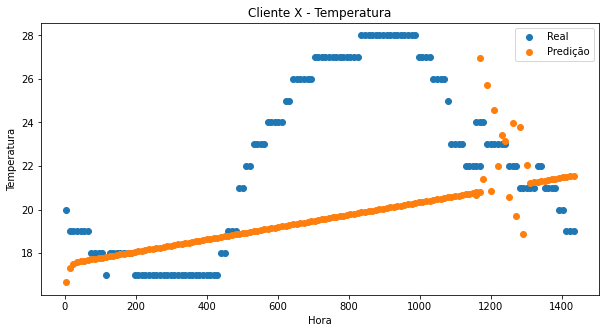

In [ ]:
fig = plt.figure()

plt.plot(x_1.datetime, x_1['temperature real'], 'o', label='Real');

plt.plot(x_1.datetime, x_1['temperature predict'], 'o', label='Predição');

plt.xlabel('Hora')
plt.ylabel('Temperatura')

plt.title("Cliente X - Temperatura")

plt.legend()

fig.set_size_inches(10, 5)
plt.show()

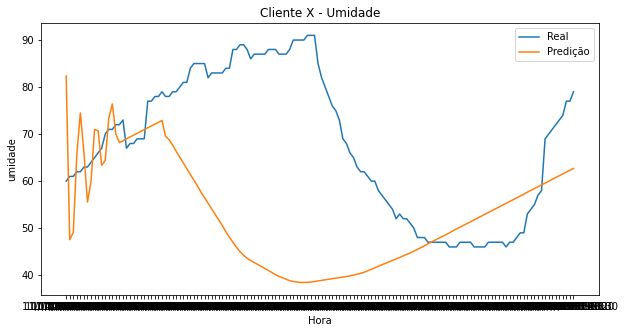

In [ ]:
fig = plt.figure()

plt.plot(x_2.datetime, x_2['humidity real'], label='Real');

plt.plot(x_2.datetime, x_2['humidity predict'], label='Predição');

plt.ylabel('umidade')
plt.xlabel('Hora')

plt.title("Cliente X - Umidade")

plt.legend()

fig.set_size_inches(10, 5)
plt.show()

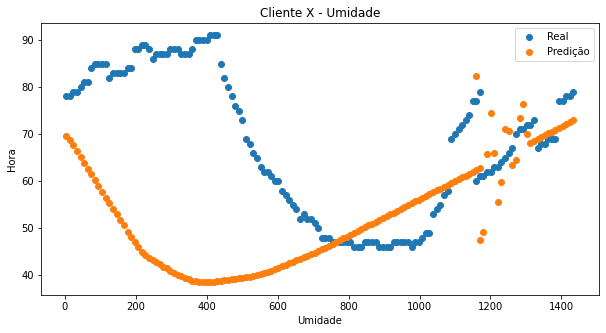

In [ ]:
fig = plt.figure()

plt.plot(x_1.datetime, x_1['humidity real'], 'o', label='Real');

plt.plot(x_1.datetime, x_1['humidity predict'], 'o', label='Predição');

plt.xlabel('Umidade')
plt.ylabel('Hora')

plt.title("Cliente X - Umidade")

plt.legend()

fig.set_size_inches(10, 5)
plt.show()

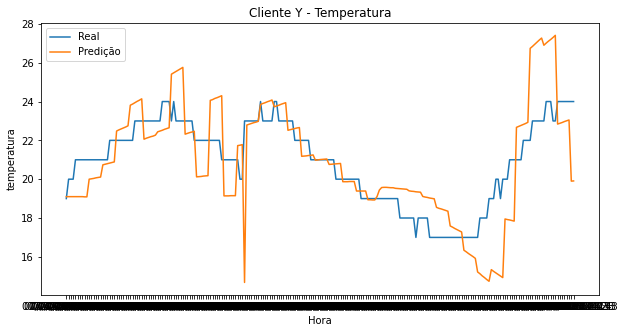

In [ ]:
fig = plt.figure()

plt.plot(y_2.datetime, y_2['temperature real'], label='Real');

plt.plot(y_2.datetime, y_2['temperature predict'], label='Predição');

plt.ylabel('temperatura')
plt.xlabel('Hora')

plt.title("Cliente Y - Temperatura")

plt.legend()

fig.set_size_inches(10, 5)
plt.show()

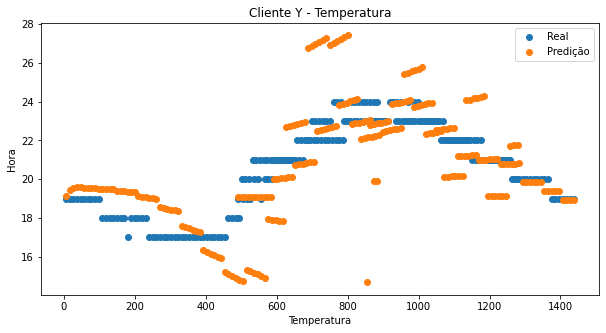

In [ ]:
fig = plt.figure()

plt.plot(y_1.datetime, y_1['temperature real'], 'o', label='Real');

plt.plot(y_1.datetime, y_1['temperature predict'], 'o', label='Predição');

plt.xlabel('Temperatura')
plt.ylabel('Hora')

plt.title("Cliente Y - Temperatura")

plt.legend()

fig.set_size_inches(10, 5)
plt.show()

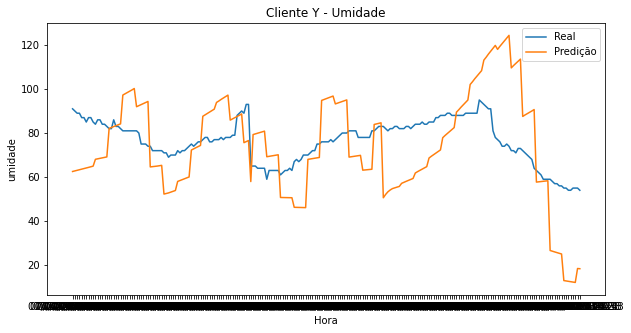

In [ ]:
fig = plt.figure()

plt.plot(y_2.datetime, y_2['humidity real'], label='Real');

plt.plot(y_2.datetime, y_2['humidity predict'], label='Predição');

plt.ylabel('umidade')
plt.xlabel('Hora')

plt.title("Cliente Y - Umidade")

plt.legend()

fig.set_size_inches(10, 5)
plt.show()

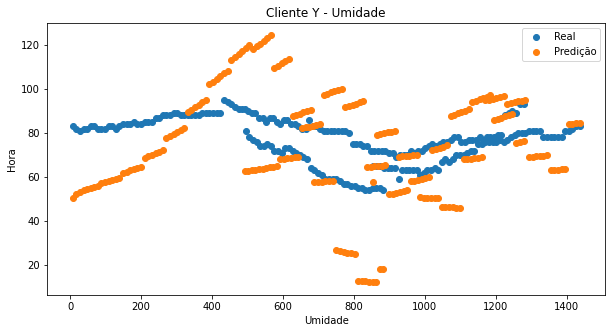

In [ ]:
fig = plt.figure()

plt.plot(y_1.datetime, y_1['humidity real'], 'o', label='Real');

plt.plot(y_1.datetime, y_1['humidity predict'], 'o', label='Predição');

plt.xlabel('Umidade')
plt.ylabel('Hora')

plt.title("Cliente Y - Umidade")

plt.legend()

fig.set_size_inches(10, 5)
plt.show()

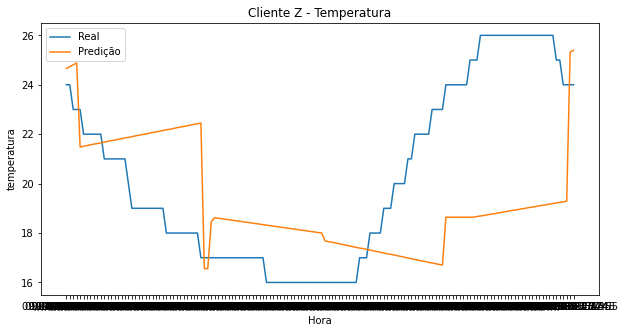

In [ ]:
fig = plt.figure()

plt.plot(z_2.datetime, z_2['temperature real'], label='Real');

plt.plot(z_2.datetime, z_2['temperature predict'], label='Predição');

plt.xlabel('Hora')
plt.ylabel('temperatura')

plt.title("Cliente Z - Temperatura")

plt.legend()

fig.set_size_inches(10, 5)
plt.show()

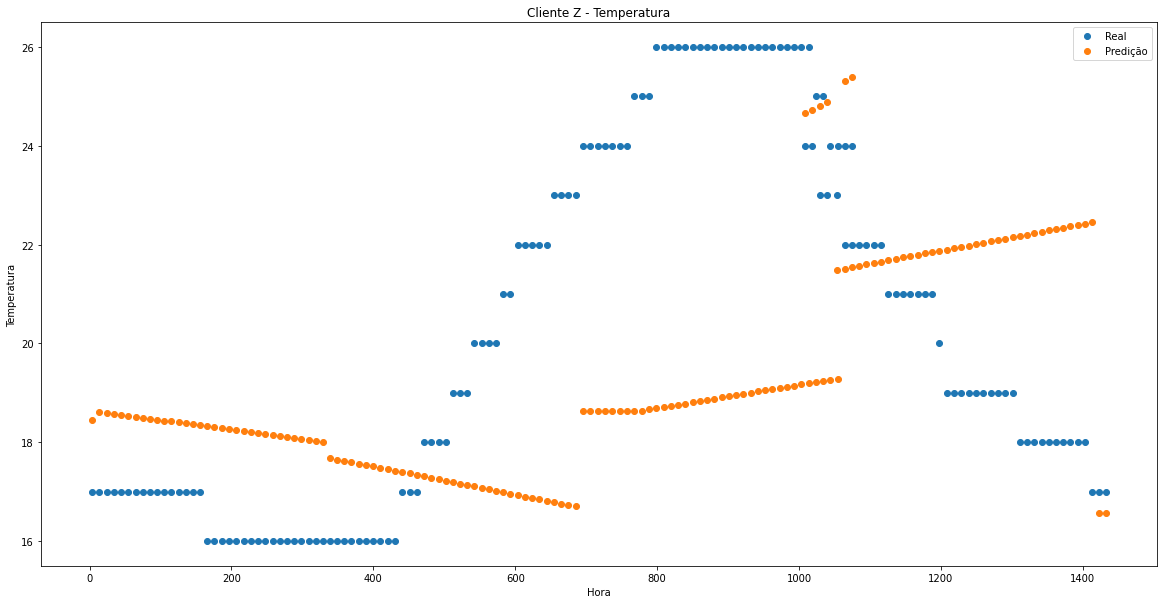

In [ ]:
fig = plt.figure()

plt.plot(z_1.datetime, z_1['temperature real'],'o', label='Real');

plt.plot(z_1.datetime, z_1['temperature predict'], 'o', label='Predição');

plt.xlabel('Hora')
plt.ylabel('Temperatura')

plt.title("Cliente Z - Temperatura")

plt.legend()

fig.set_size_inches(20, 10)
plt.show()

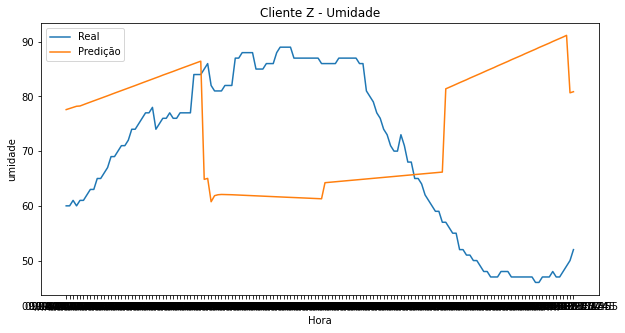

In [ ]:
fig = plt.figure()

plt.plot(z_2.datetime, z_2['humidity real'], label='Real');

plt.plot(z_2.datetime, z_2['humidity predict'], label='Predição');

plt.xlabel('Hora')
plt.ylabel('umidade')

plt.title("Cliente Z - Umidade")

plt.legend()

fig.set_size_inches(10, 5)
plt.show()

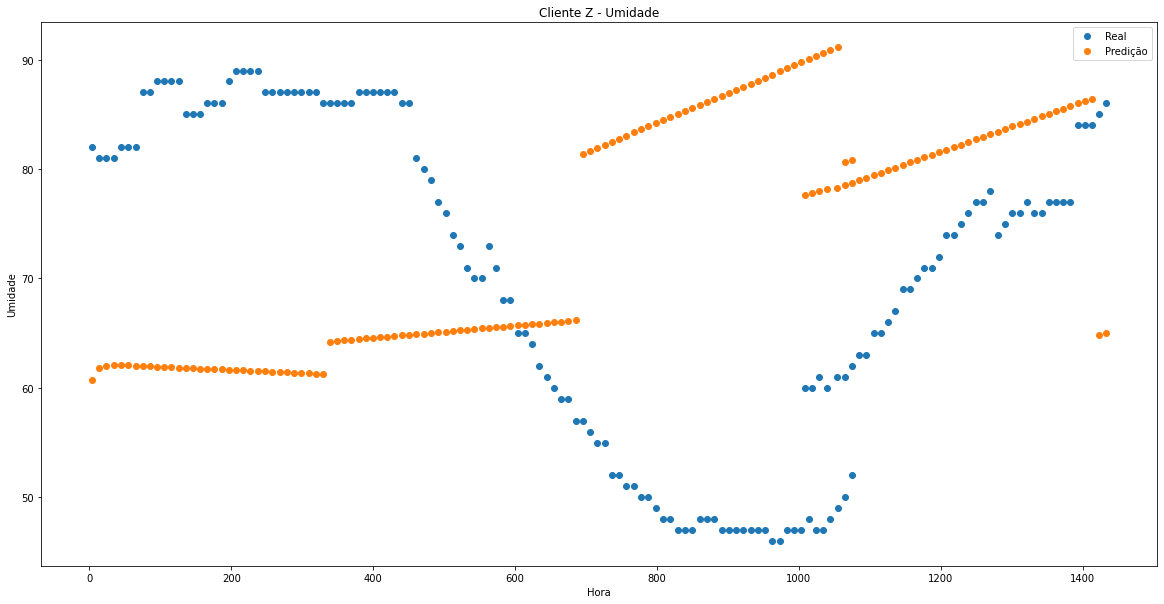

In [ ]:
fig = plt.figure()

plt.plot(z_1.datetime, z_1['humidity real'], 'o', label='Real');

plt.plot(z_1.datetime, z_1['humidity predict'], 'o', label='Predição');

plt.xlabel('Hora')
plt.ylabel('Umidade')

plt.title("Cliente Z - Umidade")

plt.legend()

fig.set_size_inches(20, 10)
plt.show()